# Dropout

Az úgynevezett dropout , magában foglalja a zaj injektálását az egyes belső rétegek kiszámítása során az előrehaladás során, és ez a neurális hálózatok betanításának szabványos technikájává vált. <br>
A módszert dropoutnak nevezik , mert egyes neuronokat szó szerint kiejtünk tanitas közben. A tanitass során, minden iterációnál a standard dropout abból áll, hogy minden rétegben nullázzuk a csomópontok egy részét a következő réteg kiszámítása előtt. A droptout felbontja a koadaptaciot es egy zaj bekuldesevel valosul meg.

### Simple example of dropout in Flux

In [1]:
import Flux,Plots,Statistics

In [2]:
using Flux,Statistics
model = Chain(Dense(ones(3,2)), Dropout(0.4))

Chain(
  Dense(2 => 3),                        # 9 parameters
  Dropout(0.4),
) 

In [3]:
# Dropout does not have effect in the test mode
model(ones(2, 7))  

3×7 Matrix{Float64}:
 2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0

Dropout does not have effect in the test mode, but after training we can see that some nodes are 0.


In [4]:
Flux.trainmode!(model);  
model(ones(2, 7))

3×7 Matrix{Float64}:
 0.0      3.33333  3.33333  0.0      3.33333  3.33333  0.0
 3.33333  3.33333  0.0      0.0      3.33333  0.0      3.33333
 0.0      3.33333  3.33333  3.33333  0.0      3.33333  3.33333

In [14]:
?Dropout

search: Dropout dropout dropout! AlphaDropout



```
Dropout(p; [dims, rng])
```

Layer implementing [dropout](https://arxiv.org/abs/1207.0580) with the given probability. This is used as a regularisation, i.e. to reduce overfitting.

While training, it sets each input to `0` (with probability `p`) or else scales it by `1 / (1 - p)`, using the [`NNlib.dropout`](@ref) function. While testing, it has no effect.

By default the mode will switch automatically, but it can also be controlled manually via [`Flux.testmode!`](@ref).

By default every input is treated independently. With the `dims` keyword, instead it takes a random choice only along that dimension. For example `Dropout(p; dims = 3)` will randomly zero out entire channels on WHCN input (also called 2D dropout).

Keyword `rng` lets you specify a custom random number generator. (Only supported on the CPU.)

# Examples

```julia
julia> m = Chain(Dense(ones(3,2)), Dropout(0.4))
Chain(
  Dense(2 => 3),                        # 9 parameters
  Dropout(0.4),
)

julia> m(ones(2, 7))  # test mode, no effect
3×7 Matrix{Float64}:
 2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0

julia> Flux.trainmode!(m);  # equivalent to use within gradient

julia> m(ones(2, 7))
3×7 Matrix{Float64}:
 0.0      0.0      3.33333  0.0      0.0      0.0  0.0
 3.33333  0.0      3.33333  0.0      3.33333  0.0  3.33333
 3.33333  3.33333  0.0      3.33333  0.0      0.0  3.33333

julia> y = m(ones(2, 10_000));

julia> using Statistics

julia> mean(y)  # is about 2.0, same as in test mode
1.9989999999999961

julia> mean(iszero, y)  # is about 0.4
0.4003
```


In [5]:
y = model(ones(2, 10_000));

In [6]:
using Statistics
# The dropout does not make a big change on the mean
print(mean(y))  


1.9808888888888878

### Using dropout in the previous MNIST problem 

In [7]:
using Flux
model = Chain(
  Dense(28*28,200, relu),Dropout(0.5),
  Dense(200,200,relu),Dropout(0.5),
  Dense(200, 10),
  softmax)

Chain(
  Dense(784 => 200, relu),              # 157_000 parameters
  Dropout(0.5),
  Dense(200 => 200, relu),              # 40_200 parameters
  Dropout(0.5),
  Dense(200 => 10),                     # 2_010 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 199_210 parameters, 778.602 KiB.

In [8]:
using MLDatasets

# load training set
train_x, train_y = MNIST.traindata();

# load test set
test_x,  test_y  = MNIST.testdata();

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Peter.Katalin\.julia\packages\MLDatasets\bg0uc\src\datasets\vision\mnist.jl:187


This program has requested access to the data dependency MNIST.
which is not currently installed. It can be installed automatically, and you will not see this message again.

Dataset: THE MNIST DATABASE of handwritten digits
Authors: Yann LeCun, Corinna Cortes, Christopher J.C. Burges
Website: http://yann.lecun.com/exdb/mnist/

[LeCun et al., 1998a]
    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner.
    "Gradient-based learning applied to document recognition."
    Proceedings of the IEEE, 86(11):2278-2324, November 1998

The files are available for download at the offical
website linked above. Note that using the data
responsibly and respecting copyright remains your
responsibility. The authors of MNIST aren't really
explicit about any terms of use, so please read the
website to make sure you want to download the
dataset.



Do you want to download the dataset from ["https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz", "https://ossci-datasets.s3.amazonaws.com/mn

┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets C:\Users\Peter.Katalin\.julia\packages\MLDatasets\bg0uc\src\datasets\vision\mnist.jl:195


In [9]:
x_train = Float32.(train_x)
y_train = Flux.onehotbatch(train_y, 0:9);

x_test = Float32.(test_x)
y_test = Flux.onehotbatch(test_y, 0:9);

loss(X, y) = Flux.crossentropy(model(X), y)
opt = Flux.ADAM();

In [10]:
using Statistics

function calculate_accuracy_test()
    test_data = [(Flux.flatten(x_test), test_y)]
    accuracy = 0
    err=0;
    nr_of_errors=0
    for i in 1:length(test_y)
        if findmax(model(test_data[1][1][:, i]))[2] - 1  == test_y[i]
            accuracy = accuracy + 1
        else
            nr_of_errors=nr_of_errors+1
            A=abs.(model(test_data[1][1][:, i]) .- y_test[:,i])
            aux=0
            for a in A
                aux=aux+a
            end
            err=err+aux;
        end
    end
    
    m = accuracy / length(test_y)
    n = err/ length(test_y)
    s = nr_of_errors 
    println("The val_accuracy is: ",m)
    println("Mean absolute error (TEST): ",n)
    println("Number of errors: ",s)
    return m,n,s
end;

In [11]:
#with this function we'll calculate the accuracy in every epoch
using Statistics

function calculate_accuracy_train()
    train_data = [(Flux.flatten(x_train), train_y)]
    err=0;
    for i in 1:length(train_y)
        if findmax(model(train_data[1][1][:, i]))[2] - 1  != train_y[i]
            A=abs.(model(train_data[1][1][:, i]) .- y_train[:,i])
            aux=0
            for a in A
                aux=aux+a
            end
            err=err+aux;
        end
    end    
    n = err/ length(train_y)
    println("Mean absolute error (TRAIN): ",n)
    return n
end;

In [12]:
using Flux

parameters = Flux.params(model)
# flatten() function converts array 28x28x60000 into 784x60000 
train_data = [(Flux.flatten(x_train), Flux.flatten(y_train))]

val_acc=zeros(0)
mean_err_test=zeros(0)
nr_err=zeros(0)
mean_err_train=zeros(0)
nr_of_epoch=8

for i in 1:nr_of_epoch
    println("epoch ",i)
    Flux.train!(loss, parameters, train_data, opt)
    
    n = calculate_accuracy_train()
    append!(mean_err_train,n)
    m, n, s = calculate_accuracy_test()
    append!( val_acc, m )
    append!( mean_err_test, n )
    append!( nr_err, s )
    
end

epoch 1
Mean absolute error (TRAIN): 1.1862954
The val_accuracy is: 0.3458
Mean absolute error (TEST): 1.1745566
Number of errors: 6542
epoch 2
Mean absolute error (TRAIN): 0.93930775
The val_accuracy is: 0.4763
Mean absolute error (TEST): 0.9334824
Number of errors: 5237
epoch 3
Mean absolute error (TRAIN): 0.779153
The val_accuracy is: 0.564
Mean absolute error (TEST): 0.77169704
Number of errors: 4360
epoch 4
Mean absolute error (TRAIN): 0.66935587
The val_accuracy is: 0.6245
Mean absolute error (TEST): 0.66029495
Number of errors: 3755
epoch 5
Mean absolute error (TRAIN): 0.59213674
The val_accuracy is: 0.6661
Mean absolute error (TEST): 0.5835435
Number of errors: 3339
epoch 6
Mean absolute error (TRAIN): 0.5363364
The val_accuracy is: 0.702
Mean absolute error (TEST): 0.51738334
Number of errors: 2980
epoch 7
Mean absolute error (TRAIN): 0.4877947
The val_accuracy is: 0.7288
Mean absolute error (TEST): 0.46759194
Number of errors: 2712
epoch 8
Mean absolute error (TRAIN): 0.45235

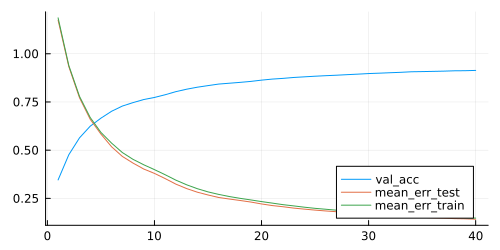

In [13]:
x = range(1, nr_of_epoch, step=1)

p= Plots.plot(x,val_acc,label="val_acc",legend=:bottomright, size=(500, 250))
p= Plots.plot!(p,x,mean_err_test,label="mean_err_test")
p= Plots.plot!(p,x,mean_err_train,label="mean_err_train")